In [5]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy import linalg

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


tf = transforms.Compose([transforms.Resize(64),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

trainset = torchvision.datasets.CIFAR10(root=".", train = True, download = True,
                                     transform = tf)


testset = torchvision.datasets.CIFAR10(root=".", train = False, download = True,
                                    transform = tf)

dataset = torch.utils.data.ConcatDataset([trainset, testset])


trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100, 
                                         num_workers = 2, shuffle = True)

print(len(dataset))
print(dataset[0][0].size())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

cuda
Files already downloaded and verified
Files already downloaded and verified
60000
torch.Size([3, 64, 64])


torch.Size([100, 3, 64, 64])


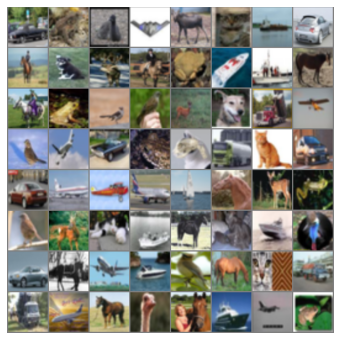

In [10]:
def showImage(images,epoch=-99, idx = -99):
    images = images.cpu().numpy()
    images = images/2 + 0.5
    plt.figure(figsize = (8,6))
    plt.imshow(np.transpose(images,axes = (1,2,0)))
    plt.axis('off')
    if epoch!=-99:
        plt.savefig("images/e" + str(epoch) + "i" + str(idx) + ".png")

dataiter = iter(trainloader)
images,labels = dataiter.__next__()
print(images.size())
showImage(make_grid(images[0:64]))

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),
                                   nn.ReLU(True))

        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),
                                   nn.Tanh())
        #output 3*64*64
      
        self.embedding = nn.Embedding(10,100)
        
        
    def forward(self,noise,label):
        
        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
        

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),
                                    nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        
        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),
                                    nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),
                                    nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),
                                    nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())
        
        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),
                                   nn.LogSoftmax(dim = 1))
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)
        
        validity = validity.view(-1)
        plabel = plabel.view(-1,11)
        
        return validity,plabel

In [13]:
def calculate_activation_statistics(images,batch_size=128, dims=2048,
                    cuda=False):
    act=np.empty((len(images), dims))
    pred=images.flatten()
    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake):
        mu_1,std_1=calculate_activation_statistics(images_real,cuda=True)
        mu_2,std_2=calculate_activation_statistics(images_fake,cuda=True)
    
        """get fretched distance"""
        fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
        return fid_value*1000


In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

disc = Discriminator().to(device)
disc.apply(weights_init)
print(disc)

paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))        
        
optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 100
Gloss=[]
Dloss=[]

for epoch in range(1,epochs+1):
    
    for idx, (images,labels) in enumerate(trainloader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)       
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())       
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
        Dloss.append(errD)
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        Gloss.append(errG)
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        fretchet_dist=calculate_fretchet(images,fakes)
        if idx%100==0:
            print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] FID: {} "
                  .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,errG,errD,
                          errD_real_label + errD_fake_label + errG_label, fretchet_dist ))
        
        
        #if idx % 100 == 0:
        #    noise = torch.randn(10,100,device = device)  
        #    labels = torch.arange(0,10,dtype = torch.long,device = device)
            
        #    gen_images = gen(noise,labels).detach()
            
        #    showImage(make_grid(gen_images),epoch,idx)
       
    
torch.save(gen.state_dict(),'gen.pth')
torch.save(disc.state_dict(),'disc.pth')

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

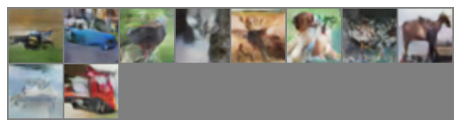

In [17]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)
            
gen_images = gen(noise,labels).detach()
            
showImage(make_grid(gen_images),epoch,idx)
       


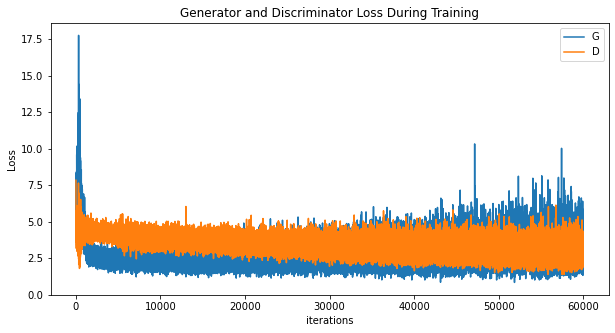

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(torch.tensor(Gloss),label="G")
plt.plot(torch.tensor(Dloss),label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()